# SMS Spam Detection using Tensorflow
we will create three models (Dense Embedding, Bi-LSTM, Transfer Learning), and use Universal Sentence Encoder also the the  validation metrics are Accuracy, Precesion, Recall, F2-score, in the end, visualization will be done. the target is to filter the recieving SMS to protect users from spam. 

## Step 1: Import Libraries

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Step 2: Loading Dataset

In [89]:
!wget https://raw.githubusercontent.com/fatahrahimi330/100-Machine-Learning-Projects/refs/heads/master/2-SMS-Spam-Detection/spam.csv

--2026-03-01 08:10:37--  https://raw.githubusercontent.com/fatahrahimi330/100-Machine-Learning-Projects/refs/heads/master/2-SMS-Spam-Detection/spam.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 498198 (487K) [text/plain]
Saving to: ‘spam.csv.1’

spam.csv.1          100%[===================>] 486.52K  --.-KB/s    in 0.02s   

2026-03-01 08:10:37 (28.7 MB/s) - ‘spam.csv.1’ saved [498198/498198]



In [90]:
df = pd.read_csv('spam.csv')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


## Step 3: Clean the Dataset and Encode the Target
For cleaning the this dataset, follow the three steps:
1. Dropping the irrelevant columns which have NaN
1. Renaming the columns name, v2->SMS and v1-> Target
1. Encodding the Target to 0 for not spam and 1 for spam

In [91]:
# 1) Dropping the irrelevant columns
df = df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)

# 2) Renaming v2 to SMS and v1 to Target
df = df.rename(columns={'v1': 'Target', 'v2':'SMS'})

# 3) Encoding the Target 0(not spam) and 1 (spam)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Target'] = le.fit_transform(df['Target'])
df.head()

,Target,SMS
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


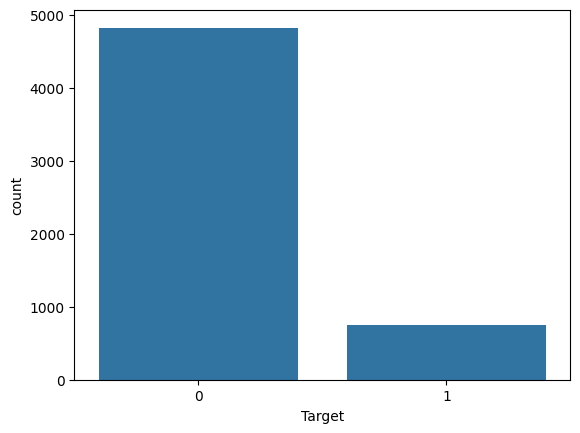

In [125]:
# let's visualize the target or label to see the data distribution
sns.countplot(x="Target", data=df)
plt.show()

## Step 4: Spliting Data into Train and Test Set

In [92]:
X = df.SMS.values
y = df.Target.values

In [93]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Step 5: Compute SMS Statistics for Vectorization

In [94]:
# 1) compute average number of words for padding
avg_num_word = round(sum([len(i.split()) for i in df['SMS']]) / len(df['SMS']))

# 2) Finding Vocabulary size
total_word_len = len(set(' '.join(df.SMS).split()))
# 3) prints basic statistic for references
print(f"Training Sample: {len(x_train)}")
print(f"Average words per Message: {avg_num_word}")
print(f"Vocabulary Size: {total_word_len}")

Training Sample: 4457
Average words per Message: 16
Vocabulary Size: 15686


## Step 6: Helper Function for Training and Evaluation

In [105]:
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compile_and_fit(model, epochs):
    model.compile(
        loss = tf.keras.losses.binary_crossentropy,
        optimizer = tf.keras.optimizers.Adam(),
        metrics = ['accuracy'],
        jit_compile=False,
    )

    callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
    history = model.fit(x_train, y_train,
                        epochs = epochs,
                        validation_data = (x_test, y_test),
                        callbacks=[callback]
                        )
    return history

def evaluation(model, x_test, y_test):
    y_pred = np.round(model.predict(x_test))

    return {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred)
    }
    

## Step 7: Build Text Vectorization Layer

In [96]:
text_vec = tf.keras.layers.TextVectorization(
    max_tokens = total_word_len,
    standardize = 'lower_and_strip_punctuation',
    output_mode = 'int',
    output_sequence_length = avg_num_word
)

text_vec.adapt(x_train)

## Step 8: Model 1 (Dense Embedding Model)

In [97]:
# for model we use the functional api not sequential one, although there is no big difference between them
input_layer = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = text_vec(input_layer)
x = tf.keras.layers.Embedding(input_dim=total_word_len, output_dim=128)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_1 = tf.keras.Model(input_layer, output_layer, name = 'Dense_Model')
history_1 = compile_and_fit(model=model_1, epochs=5)

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8611 - loss: 0.3748 - val_accuracy: 0.9596 - val_loss: 0.1464
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9732 - loss: 0.1152 - val_accuracy: 0.9740 - val_loss: 0.0767
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9878 - loss: 0.0458 - val_accuracy: 0.9776 - val_loss: 0.0673
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9952 - loss: 0.0198 - val_accuracy: 0.9776 - val_loss: 0.0666
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9969 - loss: 0.0156 - val_accuracy: 0.9803 - val_loss: 0.0637


In [98]:
model_1.summary()

Model: "Dense_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_2            │ (None, 16)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_9 (Embedding)         │ (None, 16, 128)        │     2,007,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_7      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,035,909 (23.03 MB)

 Trainable params: 2,011,969 (7.68 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,023,940 (15.35 MB)

## Step 9: Model 2 (Bidirectional LSTM Model)

In [99]:
input_layer = tf.keras.layers.Input(shape=(1, ), dtype=tf.string)
x = text_vec(input_layer)
x = tf.keras.layers.Embedding(input_dim=total_word_len, output_dim=128)(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_2 = tf.keras.Model(input_layer, output_layer, name='Bidirectional_LSTM_Model')
history_2 = compile_and_fit(model=model_2, epochs=5)

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9045 - loss: 0.2789 - val_accuracy: 0.9695 - val_loss: 0.1009
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9907 - loss: 0.0380 - val_accuracy: 0.9731 - val_loss: 0.0907
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9953 - loss: 0.0157 - val_accuracy: 0.9722 - val_loss: 0.1292
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9991 - loss: 0.0051 - val_accuracy: 0.9794 - val_loss: 0.1240
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9986 - loss: 0.0057 - val_accuracy: 0.9794 - val_loss: 0.1136


In [100]:
model_2.summary()

Model: "Bidirectional_LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_2            │ (None, 16)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_10 (Embedding)        │ (None, 16, 128)        │     2,007,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 16, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,628,805 (25.29 MB)

 Trainable params: 2,209,601 (8.43 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,419,204 (16.86 MB)

## Step 10: Model 3 (Transfer Learning with universal Sentence Encoder)

In [101]:
import tensorflow_hub as hub
use_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    trainable = False,
    input_shape = [],
    dtype = tf.string,
    name = 'USE'
)

input_layer = tf.keras.layers.Input(shape=[], dtype=tf.string)
embedding = tf.keras.layers.Lambda(lambda x: use_layer(x), output_shape=(512, ))(input_layer)
x = tf.keras.layers.Dense(64, activation='relu')(embedding)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_3 = tf.keras.Model(input_layer, output_layer, name= "USE_Model")
# history_3 = compile_and_fit(model=model_3, epochs=5)


In [102]:
history_3 = compile_and_fit(model=model_3, epochs=5)

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.8464 - loss: 0.4636 - val_accuracy: 0.9713 - val_loss: 0.1178
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9781 - loss: 0.0972 - val_accuracy: 0.9785 - val_loss: 0.0719
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9834 - loss: 0.0590 - val_accuracy: 0.9821 - val_loss: 0.0596
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9892 - loss: 0.0462 - val_accuracy: 0.9848 - val_loss: 0.0557
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9908 - loss: 0.0381 - val_accuracy: 0.9848 - val_loss: 0.0529


In [103]:
model_3.summary()

Model: "USE_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_4 (Lambda)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,693 (385.52 KB)

 Trainable params: 32,897 (128.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 65,796 (257.02 KB)

## Step 11: Collect Performance Metrics for all Models

In [108]:
results = {
    'Dense Model': evaluation(model=model_1, x_test=x_test, y_test=y_test),
    'Bidiretional LSTM Model': evaluation(model=model_2, x_test= x_test, y_test=y_test),
    'USE Model': evaluation(model=model_3, x_test=x_test, y_test=y_test)
}

result_all_model_df = pd.DataFrame(results).transpose()
result_all_model_df

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


,Accuracy,Precision,Recall,F1-Score
Dense Model,0.980269,0.970370,0.879195,0.922535
Bidiretional LSTM Model,0.979372,0.943662,0.899329,0.920962
USE Model,0.984753,0.958333,0.926174,0.941980


## Step 12: Visualization

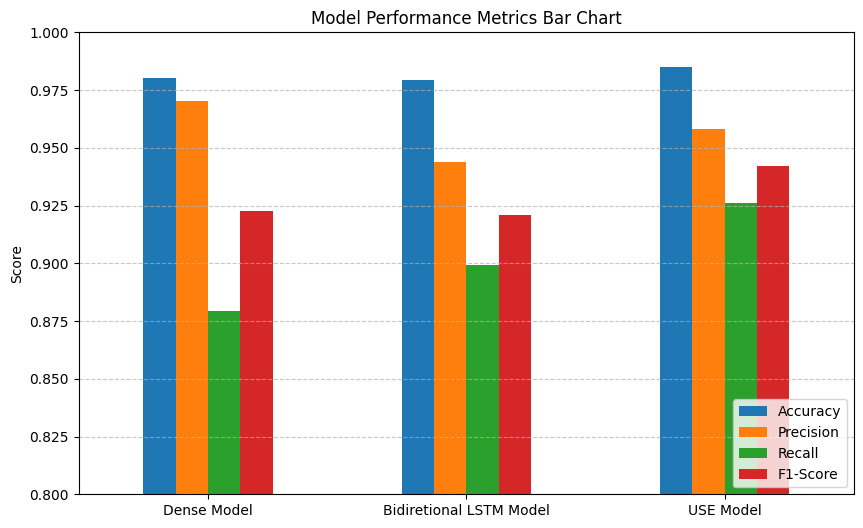

In [120]:
# a) visualize the result with Bar chart
result_all_model_df.plot(kind='bar', figsize=(10, 6))
plt.title("Model Performance Metrics Bar Chart")
plt.ylabel("Score")
plt.ylim(0.8, 1.0)
plt.xticks(rotation = 0)
plt.legend(loc = 'lower right')
plt.grid(axis='y', linestyle = '--', alpha = 0.7)
plt.show()

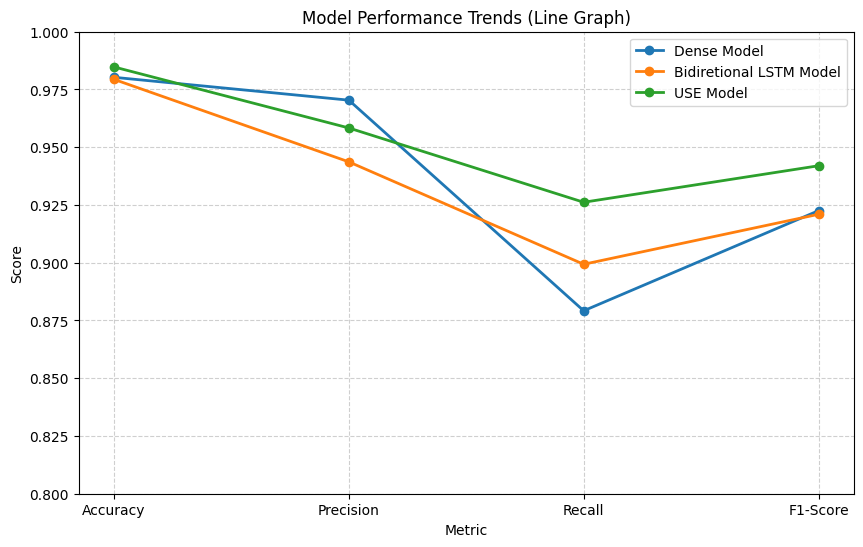

In [122]:
# b) visualize the result with line graph
plt.figure(figsize=(10, 6))
for model_name in result_all_model_df.index:
    plt.plot(result_all_model_df.columns, 
            result_all_model_df.loc[model_name], 
            marker = 'o', 
            label= model_name, 
            linewidth = 2
            )
plt.title("Model Performance Trends (Line Graph)")
plt.ylabel("Score")
plt.xlabel("Metric")
plt.ylim(0.8, 1.0)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()